# Proximal Gradient Method Example

## Import the required libraries

In [1]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
from IPython.display import display

## Define the functions

In [2]:
L = pf.Parameter("L")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)
g = pf.ConvexFunction(is_basis=True, tags=["g"])
h = (f + g).add_tag("h")

## Write a function to return the PEPContext associated with PGM

In [3]:
def make_ctx_pgm(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_pgm = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    h.set_stationary_point("x_star")
    for i in range(N):
        y = x - 1 / L * f.grad(x)
        y.add_tag(f"y_{i + 1}")
        x = g.prox(y, 1 / L, tag=f"x_{i + 1}")
    return ctx_pgm

## Numerical evidence of convergence of PGM

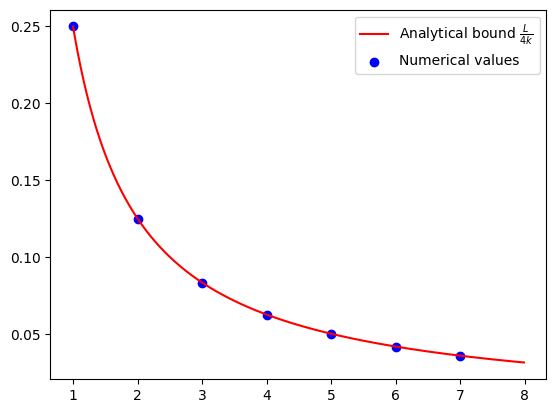

In [4]:
N = 8
R = pf.Parameter("R")
L_value = 1
R_value = 1

ctx_plt = make_ctx_pgm(ctx_name="ctx_plt", N=N, stepsize=1 / L)
pb_plt = pf.PEPBuilder(ctx_plt)
pb_plt.add_initial_constraint(
    ((ctx_plt["x_0"] - ctx_plt["x_star"]) ** 2).le(R, name="initial_condition")
)

opt_values = []
for k in range(1, N):
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(h(x_k) - h(ctx_plt["x_star"]))
    result = pb_plt.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    L_value / (4 * cont_iters),
    "r-",
    label="Analytical bound $\\frac{L}{4k}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of PGM

In [5]:
N = sp.S(2)
L_value = sp.S(1)
R_value = sp.S(1)

ctx_prf = make_ctx_pgm(ctx_name="ctx_prf", N=N, stepsize=1 / L)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["x_0"] - ctx_prf["x_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(h(ctx_prf[f"x_{N}"]) - h(ctx_prf["x_star"]))

result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variables associated with the interpolations conditions of g with no relaxation
gamm_dense = result.get_scalar_constraint_dual_value_in_numpy(g)

0.1250001921749368


In [6]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"L": L_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


### Solve the problem again with the found relaxation

In [7]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

In [8]:
relaxed_constraints = []

for tag_i in lamb_dense.row_names:
    i = tag_to_index(tag_i)
    if i == N + 1:
        continue
    for tag_j in lamb_dense.col_names:
        j = tag_to_index(tag_j)
        if i < N and i + 1 == j:
            continue
        relaxed_constraints.append(f"f:{tag_i},{tag_j}")

for tag_i in gamm_dense.row_names:
    i = tag_to_index(tag_i)
    if i == N + 1:
        continue
    for tag_j in gamm_dense.col_names:
        j = tag_to_index(tag_j)
        if i < N and i + 1 == j:
            continue
        relaxed_constraints.append(f"g:{tag_i},{tag_j}")

pb_prf.set_relaxed_constraints(relaxed_constraints)

- Solve the PEP problem again with the relaxed constraints and store the results.


In [9]:
result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})

# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the interpolations conditions of g
gamm_sol = result.get_scalar_constraint_dual_value_in_numpy(g)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

- Print the values of $\lambda$ obtained from the solver

In [10]:
lamb_sol.pprint()

<IPython.core.display.Math object>

In [11]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1:  # Additional constraint 1 (between x_★)
        if j == 0:
            return lamb("x_0", "x_1")
        elif j < N:
            return lamb(f"x_{j}", f"x_{j + 1}") - lamb(f"x_{j - 1}", f"x_{j}")
        elif j == N:
            return 1 - lamb(f"x_{N - 1}", f"x_{N}")
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return j / (2 * N + 1 - j)
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [12]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of lambda? True


### Verify closed form expression of $\gamma$

- Print the values of $\gamma$ obtained from the solver

In [13]:
gamm_sol.pprint()

<IPython.core.display.Math object>

In [14]:
def gamm(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1:  # Additional constraint 1 (between x_★)
        if 1 <= j <= N:
            return 2 * N / ((2 * N + 1 - j) * (2 * N - j))
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return (j - 1) / (2 * N + 1 - j)
    return 0


gamm_cand = pf.pprint_labeled_matrix(
    gamm, gamm_sol.row_names, gamm_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

In [15]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(gamm_cand, gamm_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of lambda? True


### Verify closed form expression $S$

- Create an ExpressionManager to translate $x_i$, $f(x_i)$, and $\nabla f(x_i)$ into a basis representation

In [16]:
pm = pf.ExpressionManager(ctx_prf, resolve_parameters={"L": L_value, "R": R_value})

- Print the values of $S$ obtained from the solver

In [17]:
S_sol.pprint()

<IPython.core.display.Math object>

- Subtract the decomposed closed-form expressions

In [18]:
x = ctx_prf.tracked_point(f)

In [19]:
S_guess1 = sum(
    N
    / ((2 * N + 1 - i) * (2 * N - i) * L)
    * (
        i / (2 * N) * f.grad(x[i])
        + (2 * N - i) / (2 * N) * f.grad(x[i - 1])
        - f.grad(x[N + 1])
    )
    ** 2
    for i in range(1, N + 1)
)

remainder1 = S_sol.matrix - pm.eval_scalar(S_guess1).inner_prod_coords
pf.pprint_labeled_matrix(remainder1, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [20]:
S_guess2 = sum(
    (
        (i - 1) / (2 * N - i) * (2 * N + 2) / (2 * N + 1)
        + 1 / (2 * N - i) ** 2 * 2 * N / (2 * N + 1)
    )
    / (2 * L)
    * (f.grad(x[i - 1]) + g.grad(x[i]) - L / (2 * N + 1 - i) * (x[i - 1] - x[N + 1]))
    ** 2
    for i in range(1, N + 1)
)

remainder2 = remainder1 - pm.eval_scalar(S_guess2).inner_prod_coords
pf.pprint_labeled_matrix(remainder2, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [21]:
S_guess3 = sum(
    i
    / (2 * N + 1 - i)
    * 2
    * N
    / (2 * N + 1)
    / (2 * L)
    * (
        (2 * N + 1) / (2 * N) * (f.grad(x[i]) + g.grad(x[i]))
        - 1 / (2 * N) * (f.grad(x[i - 1]) + g.grad(x[i]))
        - L / (2 * N - i) * (x[i] - x[N + 1])
    )
    ** 2
    for i in range(1, N + 1)
)

remainder3 = remainder2 - pm.eval_scalar(S_guess3).inner_prod_coords
pf.pprint_labeled_matrix(remainder3, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

- Check whether our candidate of $S$ matches with solution

In [22]:
S_guess = S_guess1 + S_guess2 + S_guess3
S_guess_eval = pm.eval_scalar(S_guess).inner_prod_coords
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [23]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(S_guess_eval, S_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of S? True


### Symbolic calculation

- Assemble the RHS of the proof.

In [24]:
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(ctx_prf.tracked_point(f), ctx_prf.tracked_point(f)):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)

In [25]:
for x_i, x_j in itertools.product(ctx_prf.tracked_point(g), ctx_prf.tracked_point(g)):
    if gamm(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += gamm(x_i.tag, x_j.tag) * g.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)+1/3*(g(x_2)-g(x_1)+grad_g(x_2)*(x_1-(x_2)))+1/3*(g(x_1)-g(x_star)+grad_g(x_1)*(x_star-(x_1)))+2/3*(g(x_2)-g(x_star)+grad_g(x_2)*(x_star-(x_2)))

In [26]:
RHS = interp_scalar_sum - S_guess
display(RHS)

0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)+1/3*(g(x_2)-g(x_1)+grad_g(x_2)*(x_1-(x_2)))+1/3*(g(x_1)-g(x_star)+grad_g(x_1)*(x_star-(x_1)))+2/3*(g(x_2)-g(x_star)+grad_g(x_2)*(x_star-(x_2)))-(0+2/12*L*|1/4*grad_f(x_1)+3/4*grad_f(x_0)-grad_f(x_star)|^2+2/6*L*|1/2*grad_f(x_2)+1/2*grad_f(x_1)-grad_f(x_star)|^2+0+4/45/2*L*|grad_f(x_0)+grad_g(x_1)-L/4*(x_0-x_star)|^2+4/5/2*L*|grad_f(x_1)+grad_g(x_2)-L/3*(x_1-x_star)|^2+0+1/5/2*L*|5/4*(grad_f(x_1)+grad_g(x_1))-1/4*(grad_f(x_0)+grad_g(x_1))-L/3*(x_1-x_star)|^2+8/15/2*L*|5/4*(grad_f(x_2)+grad_g(x_2))-1/4*(grad_f(x_1)+grad_g(x_2))-L/2*(x_2-x_star)|^2)

- Assemble the LHS of the proof

In [27]:
LHS = h(x[N]) - h(ctx_prf["x_star"]) - L / (4 * N) * (x[0] - ctx_prf["x_star"]) ** 2
display(LHS)

f(x_2)+g(x_2)-(f(x_star)+g(x_star))-L/8*|x_0-x_star|^2

In [28]:
diff = LHS - RHS
display(diff)

f(x_2)+g(x_2)-(f(x_star)+g(x_star))-L/8*|x_0-x_star|^2-(0+1/4*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+2/3*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+1/4*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+5/12*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+1/3*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|grad_f(x_star)-grad_f(x_2)|^2)+1/3*(g(x_2)-g(x_1)+grad_g(x_2)*(x_1-(x_2)))+1/3*(g(x_1)-g(x_star)+grad_g(x_1)*(x_star-(x_1)))+2/3*(g(x_2)-g(x_star)+grad_g(x_2)*(x_star-(x_2)))-(0+2/12*L*|1/4*grad_f(x_1)+3/4*grad_f(x_0)-grad_f(x_star)|^2+2/6*L*|1/2*grad_f(x_2)+1/2*grad_f(x_1)-grad_f(x_star)|^2+0+4/45/2*L*|grad_f(x_0)+grad_g(x_1)-L/4*(x_0-x_star)|^2+4/5/2*L*|grad_f(x_1)+grad_g(x_2)-L/3*(x_1-x_star)|^2+0+1/5/2*L*|5/4*(grad_f(x_1)+grad_g(x_1))-1/4*(grad_f(x_0)+grad_g(x_1))-L/3*(x_1-x_star)|^2+8/15/2*L*|5/4*(grad_f(x_2)+grad_g(x_2))-1/4*(grad_f(x_1)+grad_g(

In [29]:
pf.pprint_str(
    diff.repr_by_basis(ctx_prf, sympy_mode=True, resolve_parameters={"L": sp.S("L")})
)

<IPython.core.display.Math object>

---

#### With verified closed form expression, we have verified the below for fixed $N$

\begin{align*}
    &f(x_N) + g(x_N) - f(x_\star) - g(x_\star) - \frac{L}{4N} \|x_0 - x_\star\|^2   \\
    &= \sum_{i=1}^{N} \frac{i}{2N + 1 - i} 
\left( 
    f(x_i) - f(x_{i-1}) 
    + \langle \nabla f(x_{i-1}), x_{i-1} - x_i \rangle 
    + \frac{1}{2L} \|\nabla f(x_i) - \nabla f(x_{i-1})\|^2 
\right)
  \\ 
    &\quad + \frac{1}{N+1} 
\left( 
    f(x_N) - f(x_\star) 
    + \langle \nabla f(x_N), x_\star - x_N \rangle 
    + \frac{1}{2L} \|\nabla f(x_N) - \nabla f(x_\star)\|^2 
\right)
 \\
    &\quad + \sum_{i=1}^{N-1} 
\frac{2N + 1}{(2N + 1 - i)(2N - i)} 
\left(
    f(x_i) - f(x_\star)
    + \langle \nabla f(x_i), x_\star - x_i \rangle
    + \frac{1}{2L} \|\nabla f(x_i) - \nabla f(x_\star)\|^2
\right)
 \\
     &\quad + \frac{1}{2N}
\left(
    f(x_0) - f(x_\star)
    + \langle \nabla f(x_0), x_\star - x_0 \rangle
    + \frac{1}{2L} \|\nabla f(x_0) - \nabla f(x_\star)\|^2
\right)
 \\
     &\quad
     + \sum_{i=1}^{N}
\frac{i - 1}{2N + 1 - i}
\left(
    g(x_i) - g(x_{i-1})
    + \langle \widetilde{\nabla} g(x_i), x_{i-1} - x_i \rangle
\right)
      \\
     &\quad
     + \sum_{i=1}^{N}
\frac{2N}{(2N + 1 - i)(2N - i)}
\left(
    g(x_i) - g(x_\star)
    + \langle \widetilde{\nabla} g(x_i), x_\star - x_i \rangle
\right)
      \\
     &\quad - \sum_{i=1}^{N} \frac{2N}{(2N+1-i)(2N-i)} \frac{1}{2L} 
\left\| 
\nabla f(x_*) - \frac{i}{2N} \nabla f(x_i) - \frac{2N-i}{2N} \nabla f(x_{i-1})
\right\|^2 \\
&\quad - \sum_{i=1}^{N} \frac{i}{2N+1-i} \frac{2N}{2N+1} \frac{1}{2L} 
\left\|
\frac{2N+1}{2N} (\nabla f(x_i) + \widetilde{\nabla} g(x_i)) - \frac{1}{2N} (\nabla f(x_{i-1}) + \widetilde{\nabla} g(x_i)) - \frac{L}{2N-i} (x_i - x_*)
\right\|^2 \\
&\quad - \sum_{i=1}^{N} \left(
\frac{i-1}{2N-i} \frac{2N+2}{2N+1} + \frac{1}{(2N-i)^2} \frac{2N}{2N+1}
\right) \frac{1}{2L} 
\left\|
\nabla f(x_{i-1}) + \widetilde{\nabla} g(x_i) - \frac{L}{2N+1-i} (x_{i-1}-x_*)
\right\|^2
\end{align*}